# Twitter Sentiment Analysis

## Decision Tree Model

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Load preprocessed data

In [2]:
# Load preprocessed datasets and drop NaN values
train_df = pd.read_csv('datasets/train_preprocessed.csv').dropna(subset=['clean_text'])
test_df = pd.read_csv('datasets/test_preprocessed.csv').dropna(subset=['clean_text'])
val_df = pd.read_csv('datasets/validation_preprocessed.csv').dropna(subset=['clean_text'])

print(f"Training data: {train_df.shape}")
print(f"Testing data: {test_df.shape}")
print(f"Validation data: {val_df.shape}")

Training data: (55638, 6)
Testing data: (13895, 6)
Validation data: (1000, 6)


### Define features (X) and target (y)

In [3]:
X_train = train_df['clean_text']
y_train = train_df['label_encoded']

X_test = test_df['clean_text']
y_test = test_df['label_encoded']

X_val = val_df['clean_text']
y_val = val_df['label_encoded']

### Build Pipeline

In [4]:
# TF-IDF: Convert text to numbers. We use n-grams (1,2) to capture phrases like "not good"
# DecisionTree: The classifier

dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=25000, ngram_range=(1,2))),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Train the model
dt_pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [5]:
# Evaluate on validation set
y_val_pred = dt_pipeline.predict(X_val)

Baseline Validation Accuracy: 0.9150

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       266
           1       0.96      0.90      0.93       457
           2       0.89      0.91      0.90       277

    accuracy                           0.92      1000
   macro avg       0.91      0.92      0.91      1000
weighted avg       0.92      0.92      0.92      1000



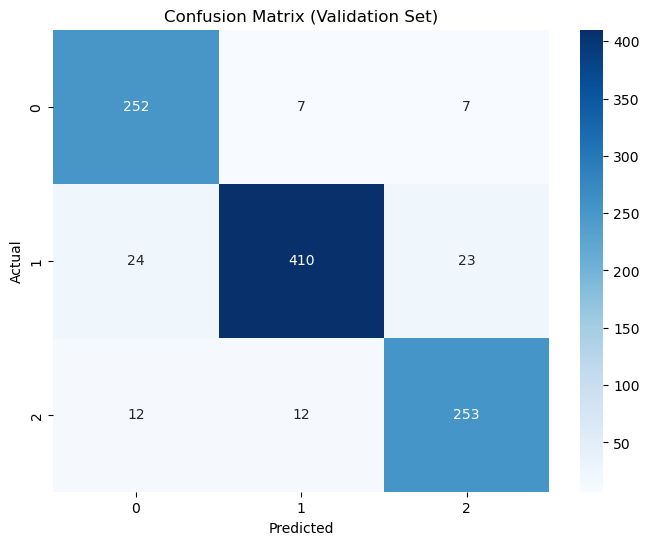

In [6]:
# Metrics
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Baseline Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred, labels=dt_pipeline.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dt_pipeline.classes_, yticklabels=dt_pipeline.classes_)
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Hyperparameter Tuning

In [7]:
from sklearn.model_selection import RandomizedSearchCV

In [8]:
param_distributions = {
    "tfidf__max_features": [5000, 10000, 20000, 30000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": [None, 20, 50, 100],
    "dt__min_samples_split": [2, 10, 50],
    "dt__min_samples_leaf": [1, 2, 5, 10],
    "dt__class_weight": [None, "balanced"]
}

# Run randomized search
random_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions = param_distributions,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting hyperparameter tuning...")
random_search.fit(X_train, y_train)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"\nBest CV Score (Macro F1): {random_search.best_score_:4f}")


Starting hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 30000, 'dt__min_samples_split': 2, 'dt__min_samples_leaf': 1, 'dt__max_depth': None, 'dt__criterion': 'entropy', 'dt__class_weight': 'balanced'}

Best CV Score (Macro F1): 0.760782


In [9]:
best_model = random_search.best_estimator_
y_val_pred_best = best_model.predict(X_val)

print(f"\nTuned Validation Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")
print(f"\nTuned Classification Report:\n{classification_report(y_val, y_val_pred_best)}")


Tuned Validation Accuracy: 0.9220

Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       266
           1       0.94      0.91      0.93       457
           2       0.92      0.91      0.91       277

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [10]:
# Check for Overfitting
print(f"Training Accuracy: {best_model.score(X_train, y_train):.4f}")
print(f"Validation Accuracy: {best_model.score(X_val, y_val):.4f}")

Training Accuracy: 0.9853
Validation Accuracy: 0.9220


### Evaluating on Test set

In [11]:
# Predict using best model
y_test_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))

Final Test Accuracy: 0.7968
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4239
           1       0.81      0.79      0.80      5837
           2       0.76      0.80      0.78      3819

    accuracy                           0.80     13895
   macro avg       0.79      0.80      0.80     13895
weighted avg       0.80      0.80      0.80     13895



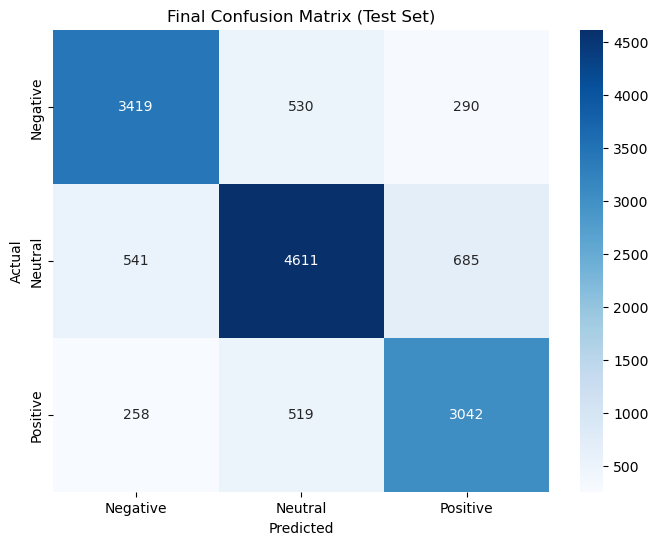

In [12]:
# Confusion Matrix for Test Data
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Final Confusion Matrix (Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
dt_depth = best_model.named_steps['dt']
depth = dt_depth.get_depth()
print(f"Depth: {depth}")
print(f"Leaves: {dt_depth.get_n_leaves()}")

Depth: 1443
Leaves: 10880
